<center>
    <img src="./Images/molssi_ai.png"
         alt="MolSSI-AI Logo"
         width=400 
         height=250
    />
</center>

## Learning Objectives
- Learn how molecules can be represented in a machine readable format
- Generate a cheminformatics data set using the RDKit library starting from a list of SMILES codes
- Create and train a random forest regression model and compare the performance to a linear regression model
- Visualizing a random forest tree
- Tune a random forest model for optimal performance 
- Brainstorm how you could add a python and/or machine learning module to a course you teach


### Importing libraries
Before we start, let's make sure we have the necessary libraries ready for use.  Once again, we will be installing a few packages that are not included in the default packages.  Remember, for the installation commands to work they must each be in their own code cell.

In [1]:
pip install rdkit

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install PandasTools

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sweetviz

Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd                 # for data manipulation
import seaborn as sns               # for data visualization
import matplotlib.pyplot as plt     # for data visualization
import numpy as np                  # for numerical operations
import sweetviz as sv               # for fast exploratory data analysis (eda)

from rdkit import Chem              # for calculating cheminformatics properties of molecules
from rdkit.Chem import Descriptors  # for determining chemical descriptors
from rdkit.Chem import Crippen      # for calculating logP (cLogP)
from rdkit.Chem import PandasTools  # for displaying molecules
PandasTools.RenderImagesInAllDataFrames(images=True) # Ensures molecules are rendered in the notebook

from sklearn.preprocessing import StandardScaler            # for scaling the data
from sklearn.model_selection import train_test_split        # for splitting the data into training and testing sets
from sklearn.model_selection import cross_val_score, KFold  # for K-fold cross-validation
from sklearn.linear_model import LinearRegression           # for creating a linear regression model
from sklearn.ensemble import RandomForestRegressor          # for creating a random forest regression model
from sklearn.dummy import DummyRegressor                    # for creating a base regressor to compare the model with
from sklearn.metrics import mean_squared_error, r2_score    # for evaluating the model
from sklearn.pipeline import make_pipeline                  # for building operational pipelines

<div class="alert alert-block alert-info">
    <b>Note</b>
    We have added comments to clarify the purpose of each imported library.
</div>

## Problem Statement

In this tutorial, we will be **creating a cheminformatics data set** from a machine-readable list of molecules. The goal is to use the provided molecules to calculate various chemical properties of each molecule and then predict the solubility of a molecule base on its chemical structure using regression models. We will re-create the pre-processed version of the [Delaney's solubility dataset](https://doi.org/10.1021/ci034243x) we used earlier.  We will then use this re-created data set for **building a Random Forest model** and compare its performance with a linear regression model. 

<br>
<br>





## SMILES Representation of Molecules

SMILES stands for "Simplified Molecular-Input Line-Entry System" and is a way to represent molecules as a string of characters.

Consider the molecule ethanol. The image below shows a representation that we are used to seeing in chemistry:

![ethanol](Images/ethanol.png)

However, the SMILES representation of this molecule would be "CCO".

You can read more about SMILES at [this tutorial](https://archive.epa.gov/med/med_archive_03/web/html/smiles.html), but rules for atoms and bonds are also repeated below.

### Atoms
SMILES supports all elements in the periodic table. An atom is represented using its respective atomic symbol. Upper case letters refer to non-aromatic atoms; lower case letters refer to aromatic atoms. If the atomic symbol has more than one letter the second letter must be lower case.

### Bonds
```
-	Single bond
=	Double bond
#	Triple bond
*	Aromatic bond
.	Disconnected structures
```
Single bonds are the default and therefore need not be entered. For example, 'CC' would mean that there is a non-aromatic carbon attached to another non-aromatic carbon by a single bond, and the computer would identify the structure as the chemical ethane. It is also assumed that the bond between two lower case atom symbols is aromatic. A blank terminates the SMILES string.

### Branches

A branch from a chain is specified by placing the SMILES symbol(s) for the branch between parenthesis. Some examples:

```

CC(O)C	2-Propanol
CC(=O)C	2-Propanone
```

### Rings

A ring is specified by placing a number directly after the SMILES symbol where the ring closure occurs. This number acts as a marker, indicating that the atoms with the same number are connected, thus forming a ring. For instance:

```
C1CCCC1 cyclopentane
n1ccccc1	Pyridine
```

### SMILES Examples

<div style="text-align:center;">
  <img src="Images/smiles_example_1.png" style="display: block; margin: 0 auto; max-height:300px;">
</div>

<div style="text-align:center;">
  <img src="Images/smiles_example_2.png" style="display: block; margin: 0 auto; max-height:300px;">
</div>

### Using Online Resources
Most of the time, you will not need to write a SMILES string by hand. You will be able to look up a molecule's SMILES string from a web database like [PubChem](https://pubchem.ncbi.nlm.nih.gov/).

You can also use tools like this [molecule sketcher from the Protein Data Bank](https://www.rcsb.org/chemical-sketch)
to draw molecules and get their SMILES strings.

### Other Molecular File Formats

Molecules can also be represented using a number of different file formats. As you work more in chemistry, you may see a number of these. Sometimes you will have to pick a file format based on the software you are using or the molecular information you want to save. 

| File Format | Description                                                                 | Features                                                              | Common Uses                              |
|-------------|-----------------------------------------------------------------------------|-----------------------------------------------------------------------|------------------------------------------|
| SMILES      | Simplified Molecular Input Line Entry System                                | Line notation for representing molecular structures                   | Database               |
| InChI       | International Chemical Identifier                                           | Textual identifier for chemical substances                            | Databases             |
| MOL/SDF     | MDL MOLfile and Structure-Data File                                         | Contains 2D/3D coordinates, atoms, bonds                              | Structure visualization, cheminformatics |
| PDB         | Protein Data Bank format                                                    | Often used for 3D structures of proteins and nucleic acids,but can also be used for small molecules. Often does not contain molecule information, and cannot store partial charges.                           | Structural biology, bioinformatics       |
| XYZ         | Cartesian coordinates                                                       | Simple text format with atom types and 3D coordinates                 | Computational chemistry, molecular dynamics |     |
| CIF         | Crystallographic Information File                                           | Text file format for representing crystal structure data              | Crystallography                          |
| PQR         | Extended PDB format with partial charges and radii                          | Includes atomic coordinates, partial charges, and radii               | Electrostatics calculations              |
| PDBQT       | PDB format with torsion angles and charges used in AutoDock                 | Includes atomic coordinates, partial charges, torsion angles          | Molecular docking                        |
|MOL2   |Tripos Mol2 format|	Contains atomic coordinates, bonds, molecule types, substructures, and partial charges|	Molecular modeling, cheminformatics, computational chemistry


# Introduction to RDKit Molecules



There are Python libraries that are made for working just with chemical data. One commonly used library in Python for data science (or cheminformatics) is called [RDKit](https://en.wikipedia.org/wiki/RDKit). RDKit is an open-source cheminformatics library, primarily developed in C++ and has been under development since the year 2000. We will be using the Python interface to RDKit, though there are interfaces in other languages.

RDKit provides a molecule object that allows you to manipulate chemical structures. It has capabilities for reading and writing molecular file formats, calculating molecular properties, and performing substructure searches. In addition, it offers a wide range of cheminformatics algorithms such as molecular fingerprint generation, similarity metrics calculation, and molecular descriptor computation. This notebook introduces RDKit basics.

<div class="alert alert-block alert-success"> 
<strong>Python Skills: Python Objects</strong>

Most of this functionality is achieved through the RDKit `mol` object. In Python, we use the word "object" to refer to a variable type with associated data and methods. 
One example of an object we have seen in notebooks is a list - we could also call it a "list object". An object has `attributes` (data) and `methods`. 
You access information about objects with the syntax
```python
object.data
```
where data is the attribute name.

You access object methods with the syntax
```python
object.method(arguments)
```
</div>    

In this lesson, we will create and manipulate RDKit `mol` objects. RDKit `mol` objects represent molecules and have
attributes (data) and methods (actions) associated with molecules.

We are going to use a part of RDKit called `Chem`. To use `Chem` we have to import it, which we did above in the importing libraries section. 

### The original data set

Let's load the list of molecules using the ``pandas`` library 
and take a look at a few samples in the dataset

In [23]:
# Path to the list of molecules data file
data_path = "./data/solubility-molecule-list.csv"

# Read the data into a DataFrame
df = pd.read_csv(data_path)

# Display the first few rows of the DataFrame
df.head()

,Compound ID,smiles,logS
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
4,Thiophene,c1ccsc1,-1.33


The dataset contains the following columns:
- **Compound ID**: compound name in a range of formats
- **smiles**: SMILES string representation of each molecule
- **logS**: the solubility of the molecule in mol/L measured at 25 $\degree$ 𝐶

### Adding molecule structures to the data set using the SMILES strings

Above we learned about molecular representations using SMILES strings. Now we will use SMILES strings to create molecule objects in RDKit. 

We can create a representation of methane using RDKit by using the `MolFromSmiles` function in `rdkit.Chem`.

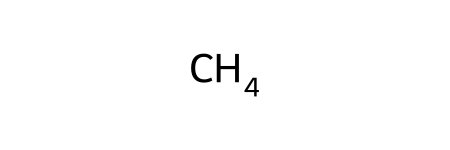

In [24]:
# visualizing methane as an example
methane = Chem.MolFromSmiles("C")
methane

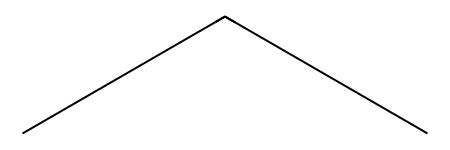

In [25]:
# visualizing propane as another example
propane = Chem.MolFromSmiles("CCC")
propane

### The `.apply` function

In the examples above, we made a single molecule object from a single SMILES string.  However, when we are working with a lot of data, we might have a whole column of SMILES strings that we need to use to make molecule objects.  Further, we would like to save those molecule objects as a new column in our pandas dataframe.  This is generally true; you often want to calculate a new column of data using an existing column in your data frame.  The way to accomplish this is to use the `.apply` method.  You access any exisiting column of your python dataframe, put `.apply()` and then in the parenthesis, list a python function that calculates the thing you want to calculate.  In the code below, we will take the column of SMILES strings and apply the `Chem.MolFromSmiles` function and save the results as a new column of the dataframe.

,Compound ID,smiles,logS,mol
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,
4,Thiophene,c1ccsc1,-1.33,

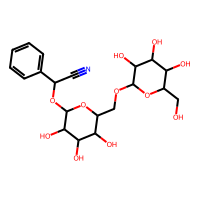
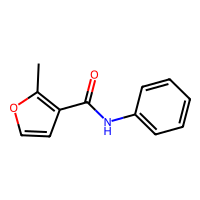
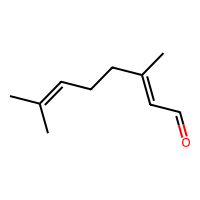
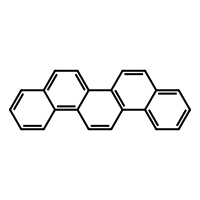
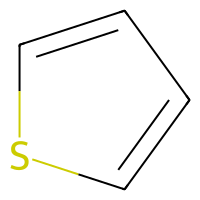

In [26]:
# visualizing all the molecules in our data set
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df.head()

RDKit molecule objects have a number of methods we can use to get more information about the molecule. In the next few cells, we'll look at some methods that can tell us some things about the molecules we've created.  

We can use the `.apply` function that we just discussed to apply these methods to our molecule objects and save the results in a new column.

### Calculating Molecular Weights

,Compound ID,smiles,logS,mol,mol_weight
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,,457.432
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,,201.225
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,,152.237
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,,278.354
4,Thiophene,c1ccsc1,-1.33,,84.143

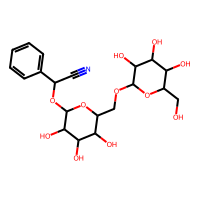
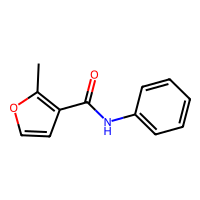
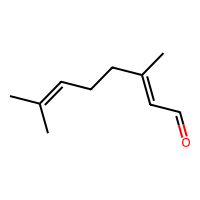
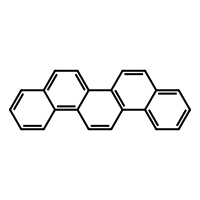
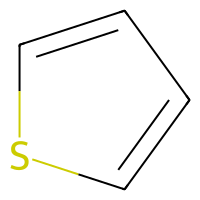

In [27]:
df['mol_weight'] =df['mol'].apply(Descriptors.MolWt)
df.head()

### Calculating number of rotatable bonds

,Compound ID,smiles,logS,mol,mol_weight,rot_bonds
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,,457.432,7
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,,201.225,2
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,,152.237,4
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,,278.354,0
4,Thiophene,c1ccsc1,-1.33,,84.143,0

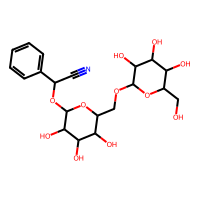
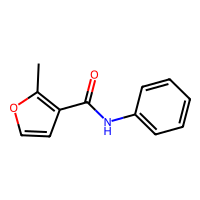
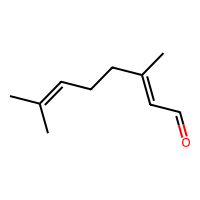
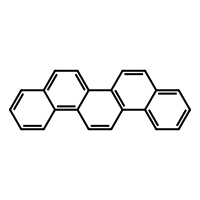
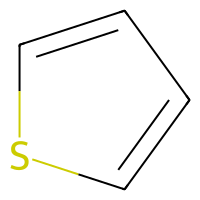

In [28]:
df['rot_bonds'] =df['mol'].apply(Chem.rdMolDescriptors.CalcNumRotatableBonds)
df.head()

### Calculating logP

This uses the Wildman-Crippen LogP value calculation, an atom-based scheme based on the values in the paper Wildman and G. M. Crippen JCICS 39 868-873 (1999)

,Compound ID,smiles,logS,mol,mol_weight,rot_bonds,clogP
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,,457.432,7,-3.10802
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,,201.225,2,2.84032
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,,152.237,4,2.87800
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,,278.354,0,6.29940
4,Thiophene,c1ccsc1,-1.33,,84.143,0,1.74810

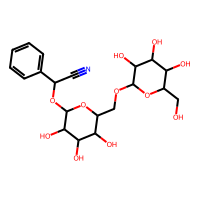
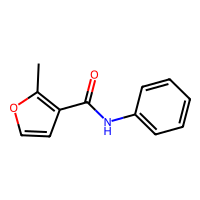
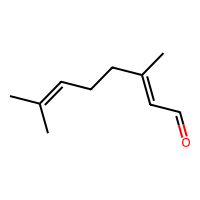
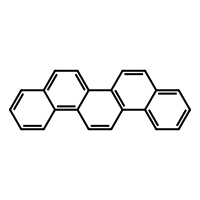
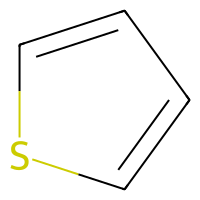

In [29]:
df['clogP'] =df['mol'].apply(Chem.Crippen.MolLogP)
df.head()

### Calculating aromatic ratio

The aromatic proportion was calculated in the original paper by dividing the number of aromatic atoms by the number of total atoms. Although there is not a function in RDKit that calculates this directly, we can calculate it by creating our own function that uses two existing RDKit functions to perform the calculation. Then we can use our new function and ``.apply`` to make a new column in our data set.

In [30]:
## defining the function that will calculate the aromatic proportion

def aromatic_calc(mol):
    prop_aromatic = len(mol.GetAromaticAtoms())/mol.GetNumAtoms()
    return prop_aromatic

,Compound ID,smiles,logS,mol,mol_weight,rot_bonds,clogP,aromatic_ratio
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,,457.432,7,-3.10802,0.187500
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,,201.225,2,2.84032,0.733333
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,,152.237,4,2.87800,0.000000
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,,278.354,0,6.29940,1.000000
4,Thiophene,c1ccsc1,-1.33,,84.143,0,1.74810,1.000000

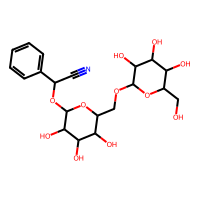
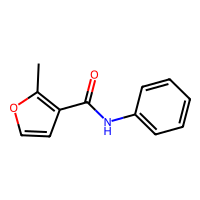
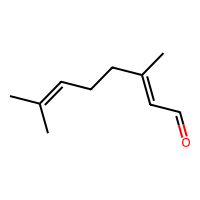
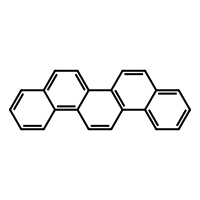
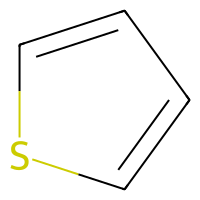

In [31]:
df['aromatic_ratio'] =df['mol'].apply(aromatic_calc)
df.head()

### Other calculations RDKit can perform

There are many other properties of molecules that RDKit can caculate.  In general, the methods in RDKit are organized into modules baesd on the type of property they calculate.  For instance, in some of the examples above, we used methods from the 
[`Descriptors` module](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html) and the [`rdMolDescriptors` module](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html).  You can click on either of those links to see the full list of the different properties you can access. 

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Look through the documentation and find some additional molecular properties you want
    to add to your dataframe.
</div>

### Exploratory Data Analysis (EDA) of the data set

The first step after stating the problem is to perform exploratory data analysis (EDA) on raw data. The EDA is crucial for data preprocessing pipelines as it helps us understand the nature of our data, identify the key patterns and relationships, and detect anomalies. The EDA involves summarizing the main characteristics of the data, often using visual methods. 

Loading the data into a Pandas DataFrame provides a convenient way to perform EDA.  We will use SweetViz, an EDA library, to verify the data we generated has no missing values and has the expected value distributions.  The molecule images, however, will cause an error. So we will create a version of the DataFrame called df_nomol with the 'mol' column dropped.

In [32]:
# dropping the mol columns

df_nomol = df.drop(columns = ['mol'])
df_nomol.head()

,Compound ID,smiles,logS,mol_weight,rot_bonds,clogP,aromatic_ratio
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,457.432,7,-3.10802,0.187500
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,201.225,2,2.84032,0.733333
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,152.237,4,2.87800,0.000000
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,278.354,0,6.29940,1.000000
4,Thiophene,c1ccsc1,-1.33,84.143,0,1.74810,1.000000


                                             |      | [  0%]   00:00 -> (? left)


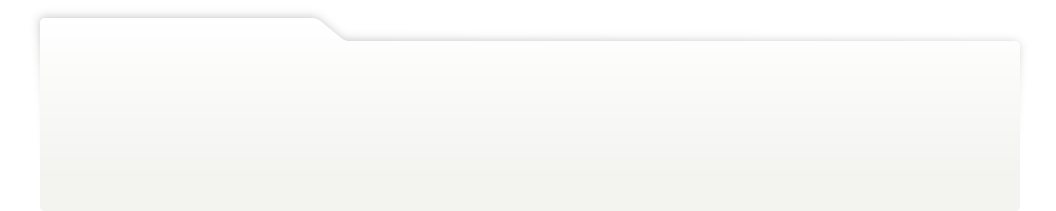
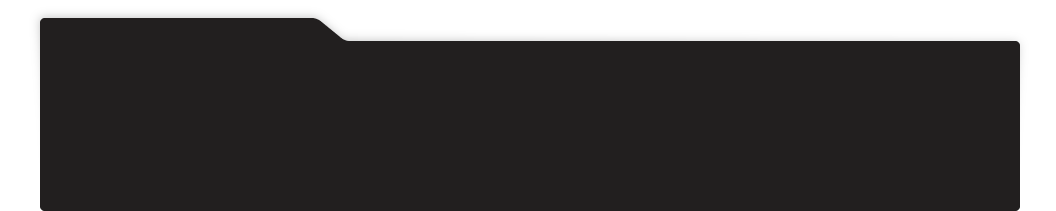
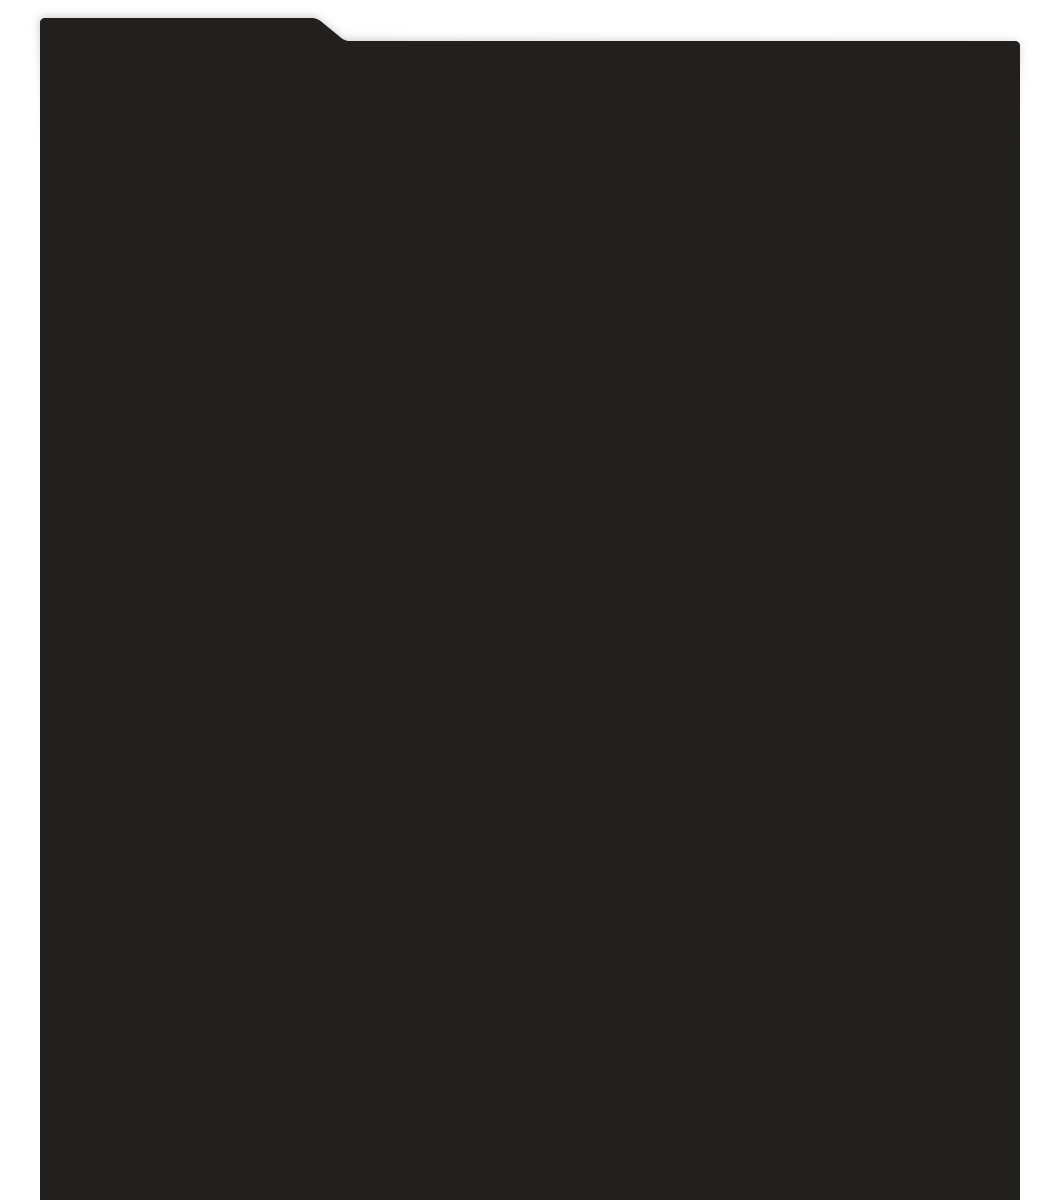
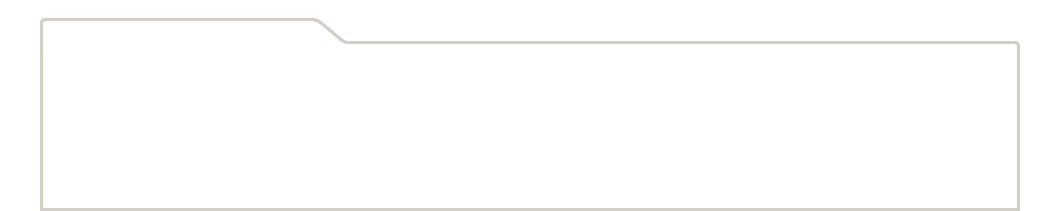
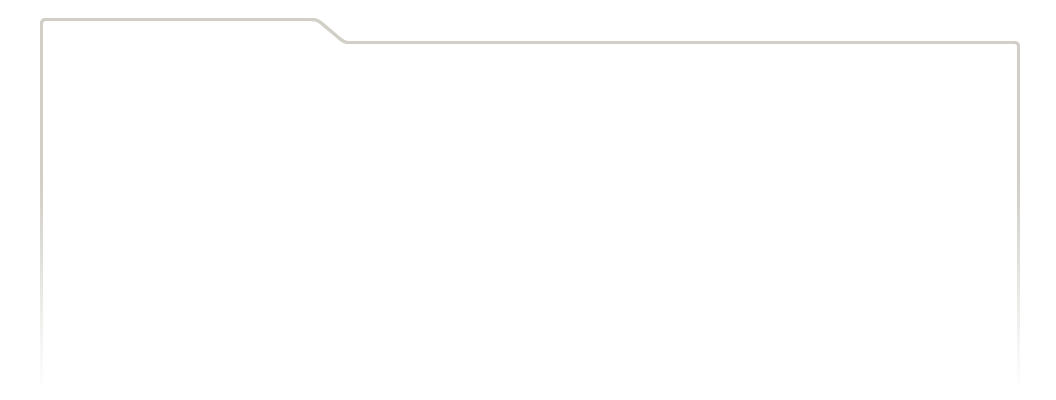
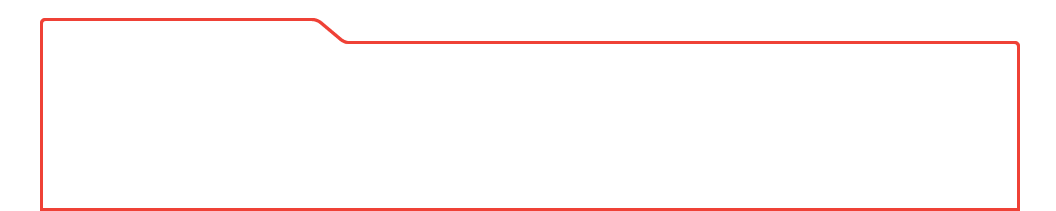
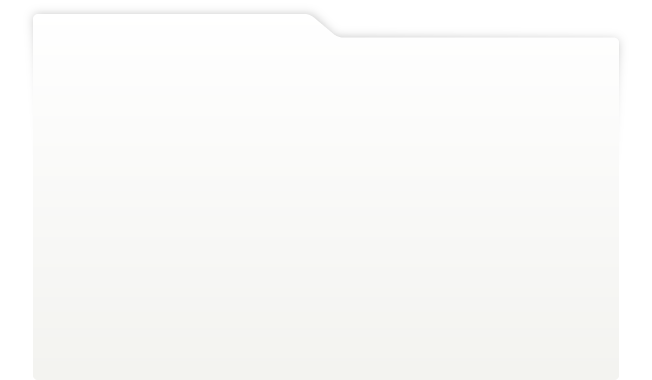
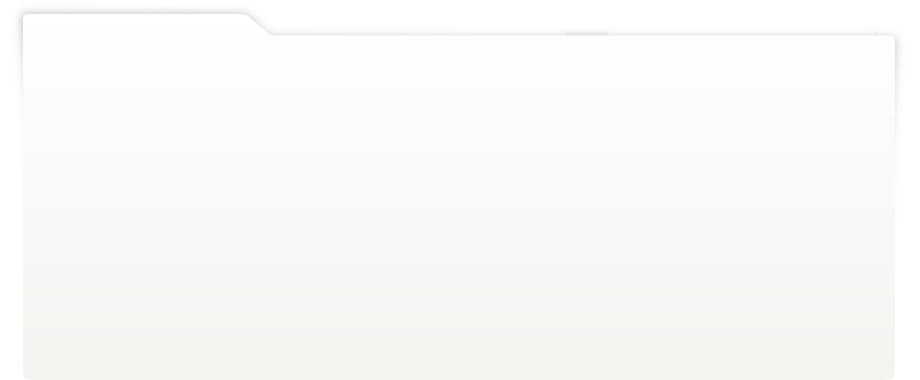
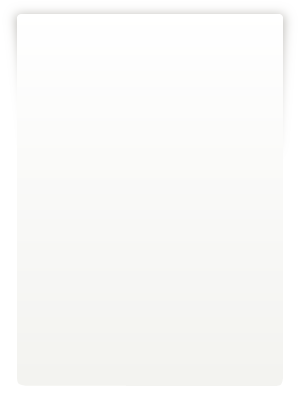
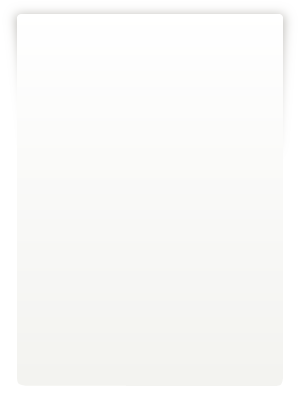
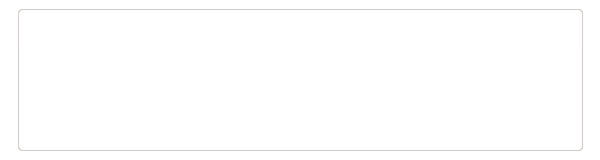
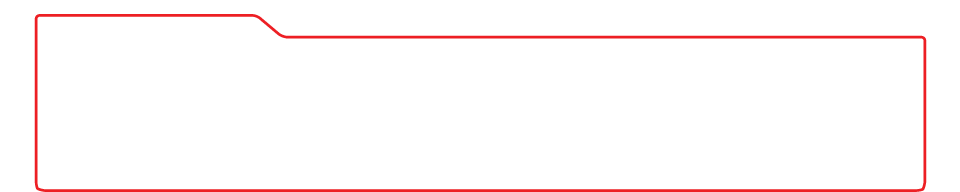
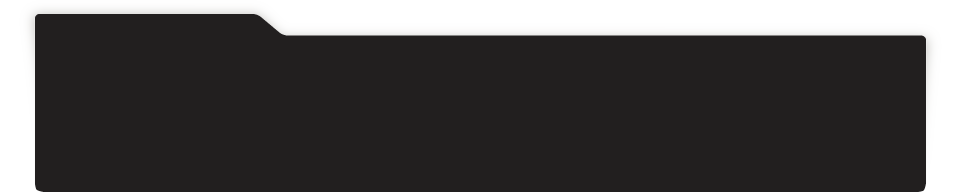
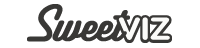
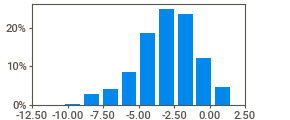
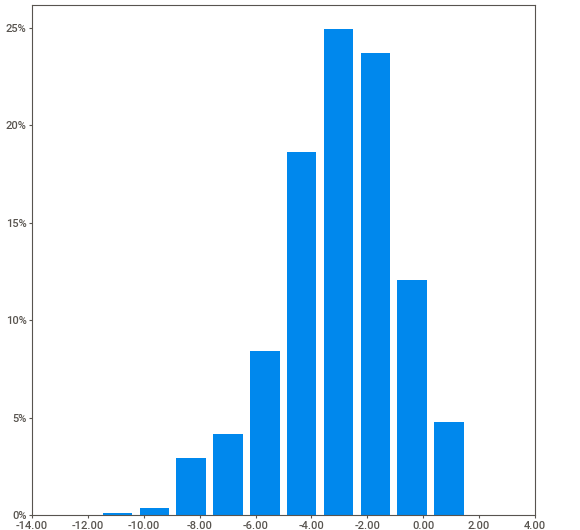
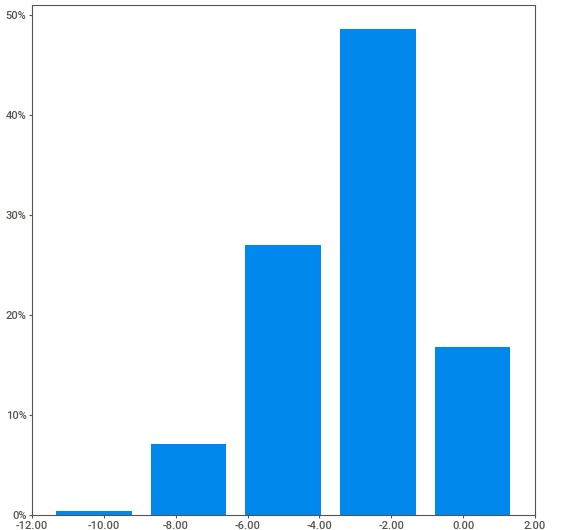
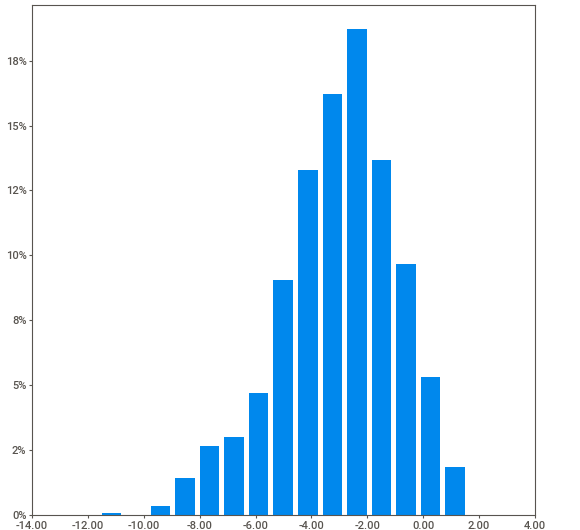
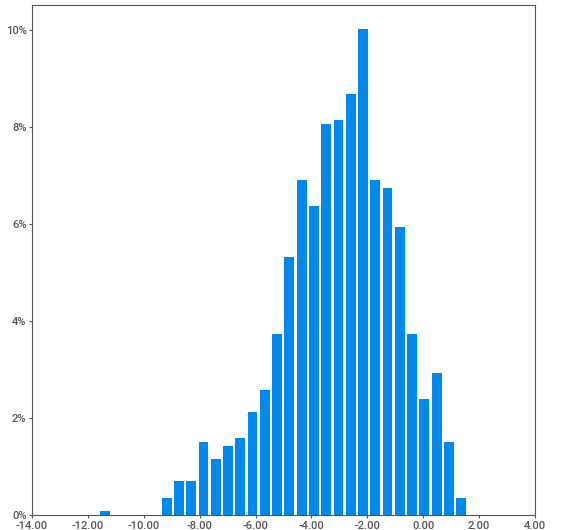
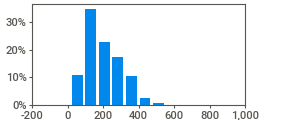
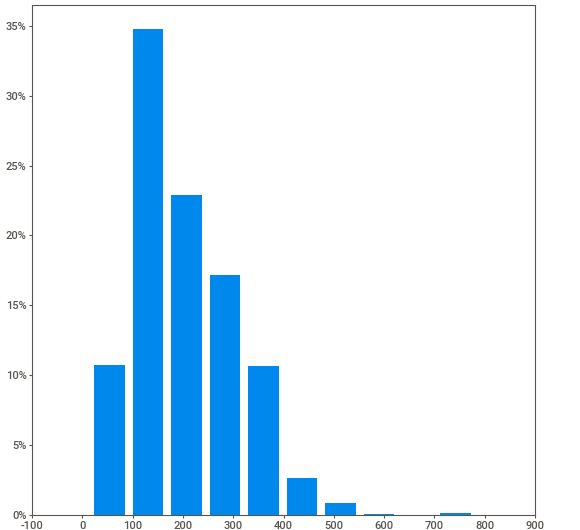
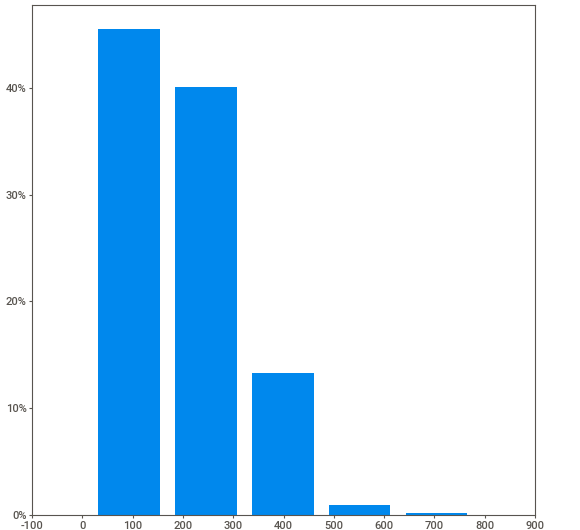
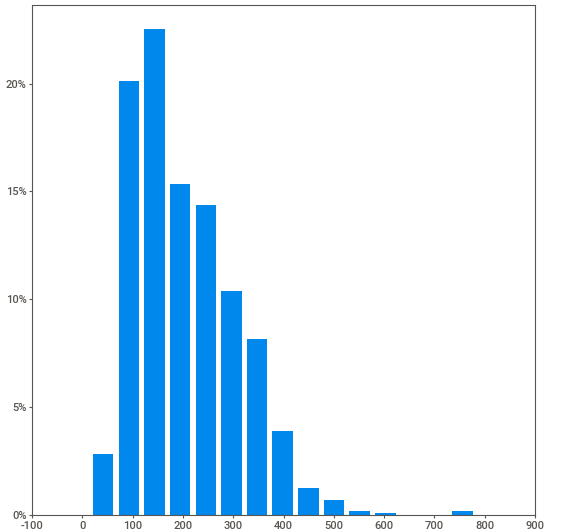
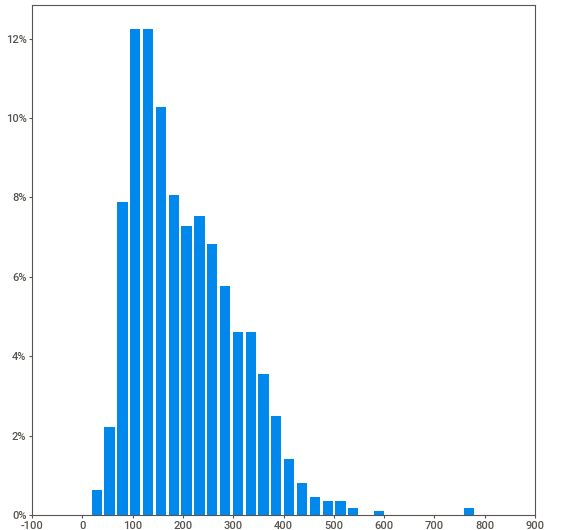
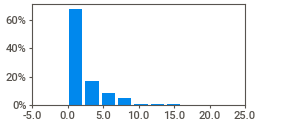
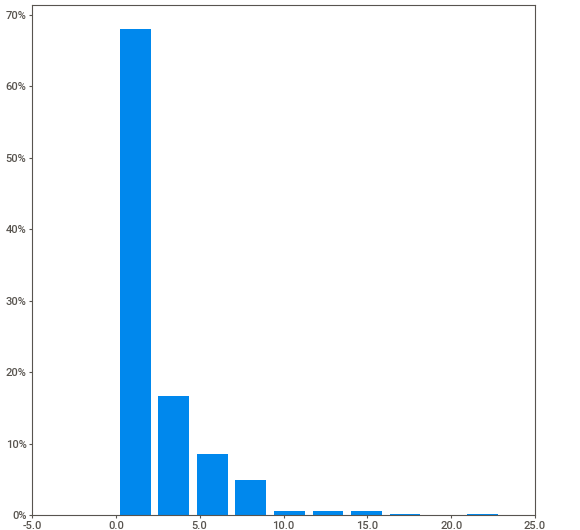
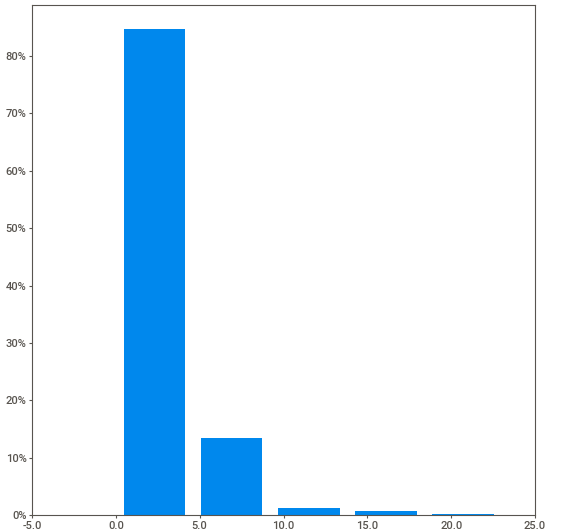
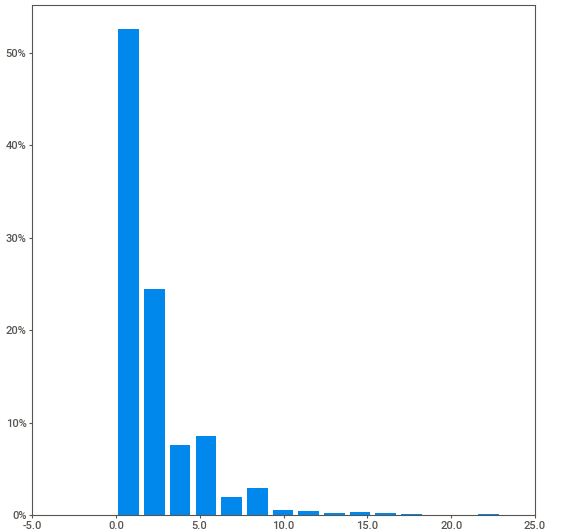
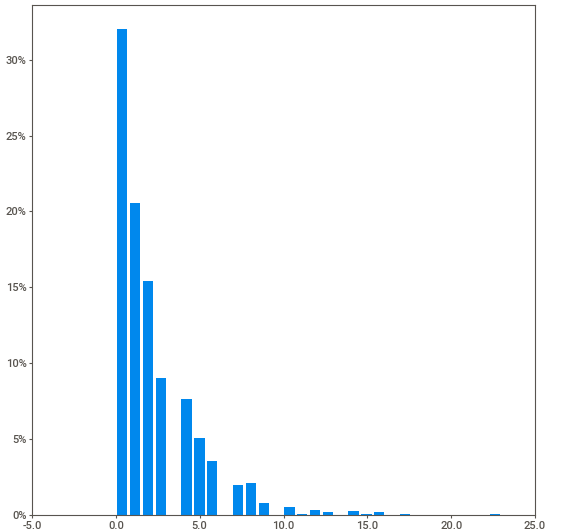
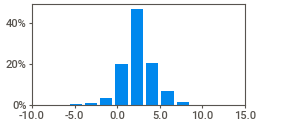
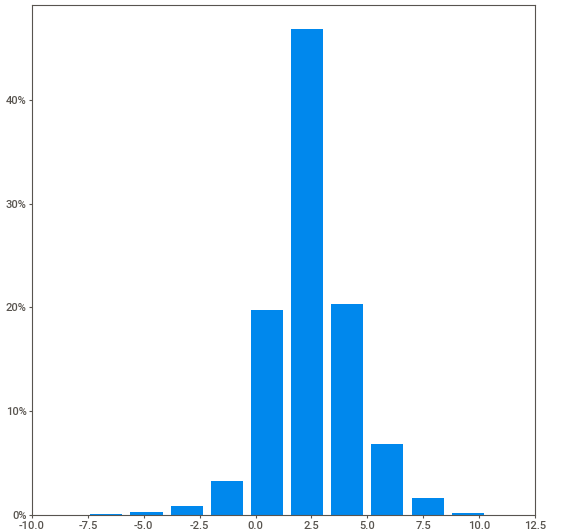
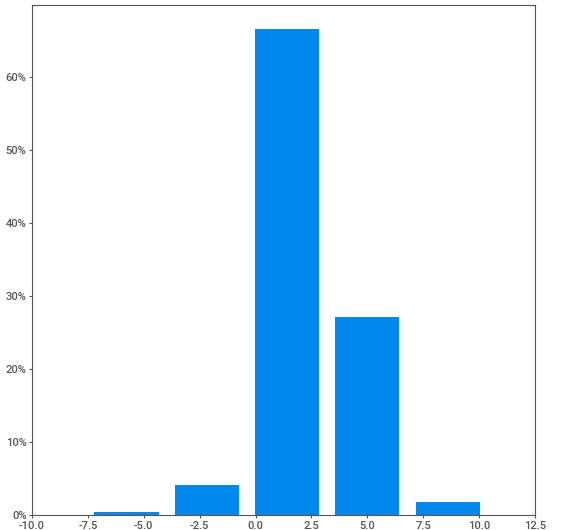
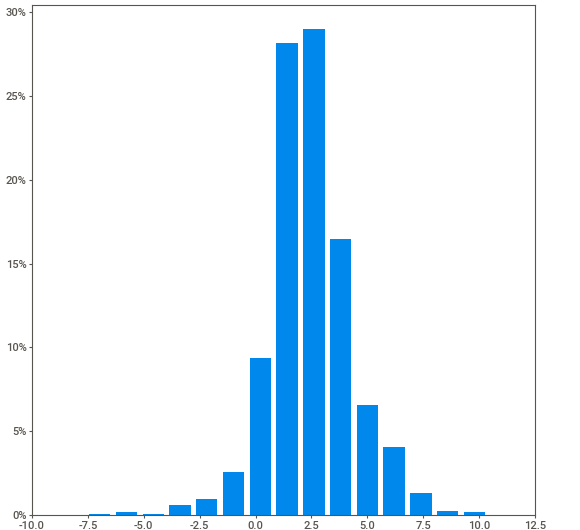
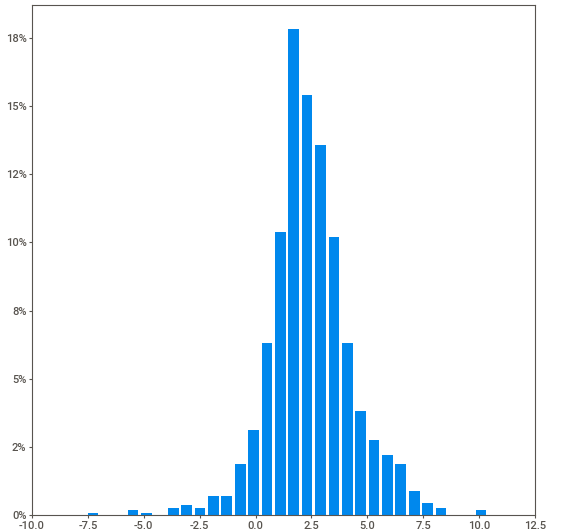
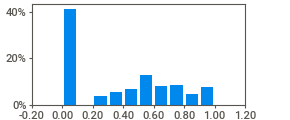
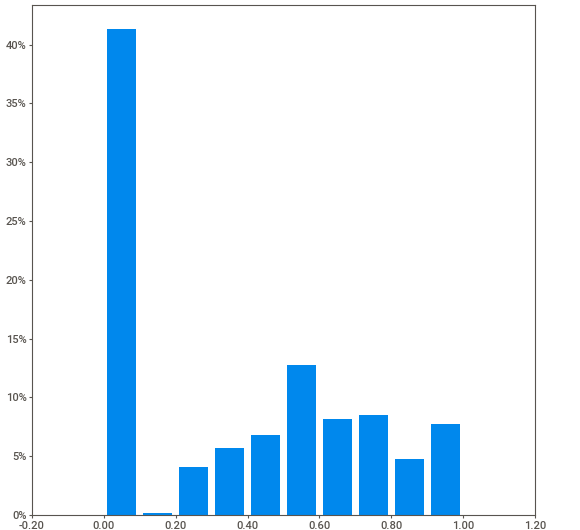
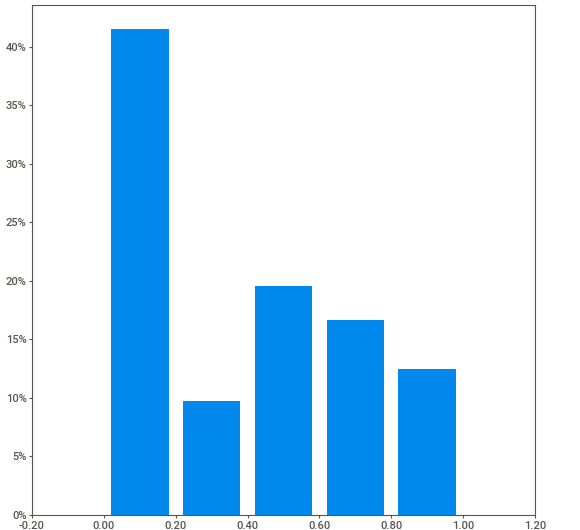
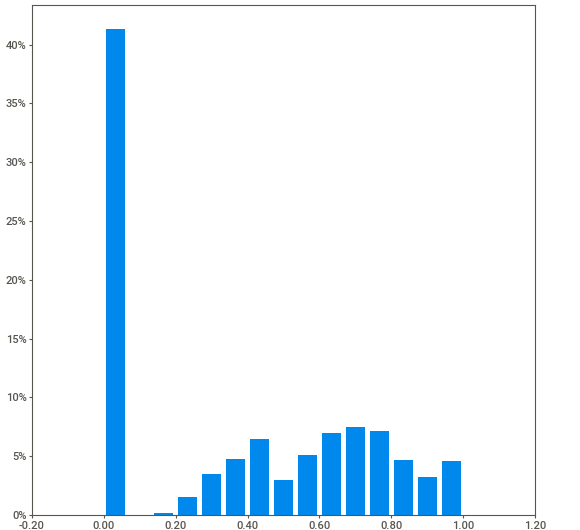
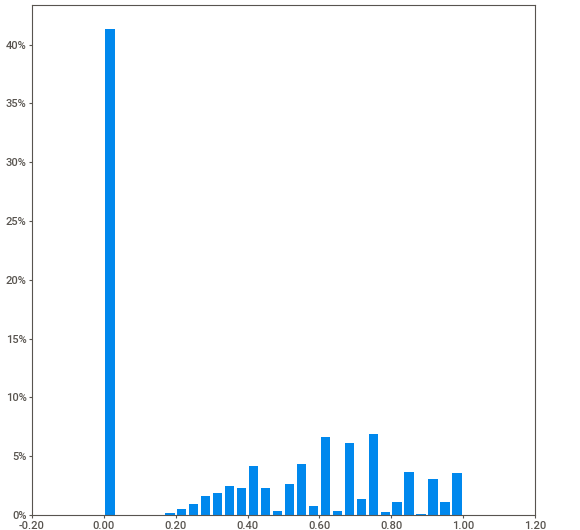
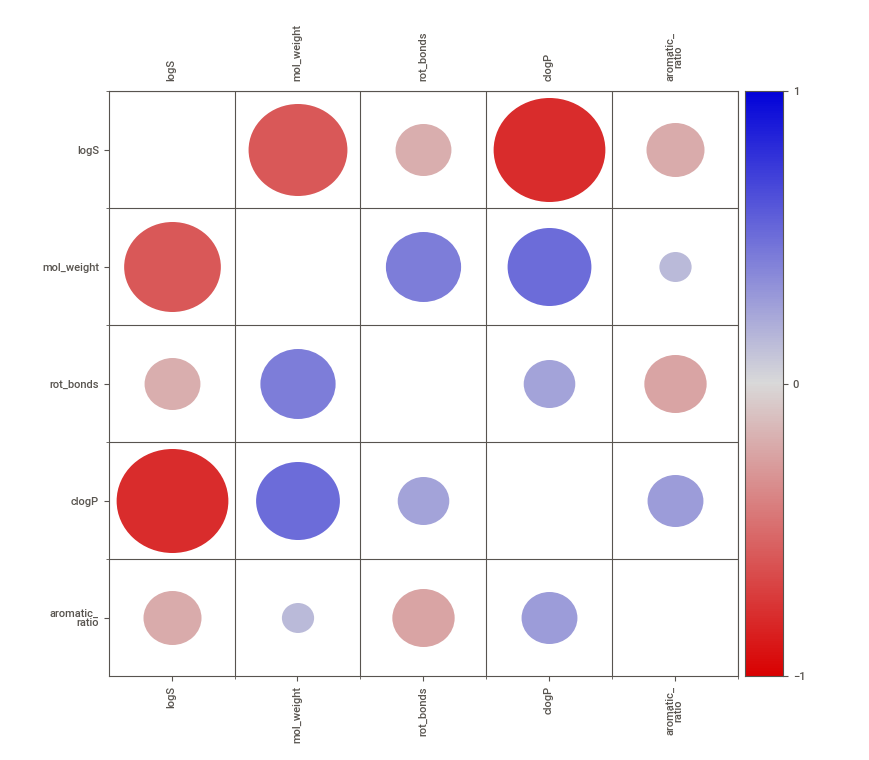
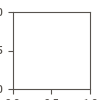

In [33]:
# Analyse Dataset
report = sv.analyze(df_nomol)

# View and Save
report.show_notebook()

### Checking for Missing Values

Since the data is already preprocessed, the number of Missing values for all features should be zero. The experimentally measured solubility in the last column logS is the target variable and the remaining columns are the features.

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Are there any missing values in the data set?
</div>

### Statistical Summary of the Data
We also see a statistical summary of each numerical features in our dataset. The provided statistics include the value counts, mean, standard deviation, minimum, 25th percentile, median, average, 75th percentile, and maximum values for each feature.

This information is extremely useful for understanding the data and the distribution of the features. It helps in identifying anomalies in the data or if our data requires any preprocessing. 

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    What is the range of the logS values in this dataset?
    </div>

### Skewness
The skewness of the data, which is determined by comparing the mean and median values, is also provided.

The numerical values of skewness can be interpreted using the following rules:
- The skewness value of zero indicates a perfect symmetrical distribution,
- a skewness between -0.5 and 0.5 indicates an approximately symmetric distribution,
- a skewness between -1 and -0.5 (or 0.5 and 1) indicates a moderately skewed distribution,
- a skewness between -1.5 and -1 (or 1 and 1.5) indicates a highly skewed distribution, and
- a skewness less than -1.5 (or greater than 1.5) indicates an extremely skewed distribution.

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Use the skewness rules and the histograms to categorize the skewness of all five properties based on the calculated skewness values.
</div>

### Correlation of Features with Target Variable
The correlation matrix between the features and the target variable provides insights into the relationships between the features and the target variable(s). You may need to click on the "Associations" button in order to see the correlation matrix.

A correlation value close to 1 indicates a strong positive relationship, while a correlation value close to -1 indicates a strong negative relationship. A correlation value close to 0 indicates no relationship between the features.

The coloring scheme makes it easy to uncover the relationships between the features. The darker the color, the stronger the correlation. The diagonal line represents the correlation of each feature with itself, which is always 1. The blue color indicates a positive correlation, while the red color signifies a negative correlation (based on the provided key).

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Based on the correlation plot, which feature is most strongly correlated with the logS value? And is it a negative or positive correlation?
</div>

## Splitting the Data Into Training and Testing Sets

Once we have a good understanding of the data, we can move on to the next step, which is splitting the data into a training set and a testing set. The training set is used to train the model, and the testing set is used to evaluate the model's performance. This process allows you to test the model's accuracy on unseen data and ensures that the model can generalize well to new data.

It is extremely important to split the data first and then perform subsequent feature engineering steps. Feature engineering prior to splitting the data can cause a <b>data leakage</b> problem, allowing the model to "see" the testing data in the training phase. This violates our intention to treat the test data as a good representative sample of the real-world data. Data leakage leads to a model that performs well in training and testing but that performs poorly when given novel data.

To create our training and testing data sets, we will use the ``train_test_split`` function from the ``sklearn.model_selection`` module to split the data. The training set will be used to train the model, while the testing set will be used to evaluate the model's performance.

Useful information about the train test split process:
- ``x`` generally denotes the input variables (the data the model will use to make predictions)
- ``y`` is often used for target variable (what we are trying to predict)
- ``test_size`` is used to assign the percentage of the data set aside for the testing set
- ``random_state`` controls the random number generator used to shuffle the data before splitting it. In other words, it ensures that the same randomization is used each time you run the code, resulting in the same splits of the data. This is especially useful if you want to compare the performance of multiple models
- ``shuffle = True`` ensures that the data is split randomly.

In [34]:
# Create the feature matrix (X), feature vector (x), and the target vector (y)
X = df.drop(columns=['logS'])
x = X["clogP"]
y = df['logS']

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)

# Reshape the data into 2D arrays of shape (n_samples, 1)
# (if working with only one input feature)
x_train = x_train.values.reshape(-1,1)
x_test = x_test.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

# Display the shapes of the training and testing sets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((902, 1), (226, 1), (902, 1), (226, 1))

<div class="alert alert-block alert-info">
    <b>Note</b>
    Note the use of the <b>x</b> vector in the <b>train_test_split</b> function as initially we will train a model using only one input feature.<br> If we instead want to use all the available features we would need to use the <b>X</b> matrix that we have defined.
</div>

## Feature Engineering

Once we have a good understanding of the data, we can move on to the next step, which is feature engineering. Feature engineering is the process of transforming the raw data into a format that is suitable for machine learning models. Feature engineering often involves creating new features, selecting the most important features, and transforming the existing features in order to improve the model's performance.

After splitting our data, we need to scale our train and test features. Scaling is a crucial step in the data preprocessing pipeline as it ensures that all features have the same scale, since many machine learning models are sensitive to the scale of the input features. We will use the ``StandardScaler`` from the ``sklearn.preprocessing`` module to scale our features. ``StandardScaler`` transforms the data in such a manner that it has mean value of 0 and a standard deviation value of 1.

In [35]:
# Create the standard scaler object
scaler = StandardScaler()

# Fit and transform the training feature vector x_train
x_train_scaled = scaler.fit_transform(x_train)

# Transform the test feature vector x_test
x_test_scaled = scaler.transform(x_test)

# Make sure the training data is scaled correctly
print(f" Training feature mean: {x_train_scaled.mean():.5f}")
print(f" Training feature standard deviation: {x_train_scaled.std():.5f}\n")

# Print the scaler statistics on the test data
print(f" Testing feature mean: {x_test_scaled.mean():.5f}")
print(f" Testing feature standard deviation: {x_test_scaled.std():.5f}")

 Training feature mean: -0.00000
 Training feature standard deviation: 1.00000

 Testing feature mean: 0.05267
 Testing feature standard deviation: 0.95624


<div class="alert alert-block alert-info">
    <b>Reminder:</b>
    It is extremely important to split the data first and then fit the scaler on the training data, only. Fitting the scaler on the entire data and then splitting it causes the <b>data leakage</b> problem which violates our intention to treat the test data as a good representative sample of the real-world data.  
</div>

## Building and Training a Linear Regression Model

The next step after the data preparation is to build and train our model. We will build a simple linear regression model which focuses on the relationship between a single feature (``MolLogP``) and the target variable (``logS``). 

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    What is the reason behind choosing <b>MolLogP</b> as our main feature in the linear regression model?
</div>

In order to evaluate the performance of our model, we can first create a dummy "model" using the ``DummyRegressor`` class from the ``sklearn.dummy`` module. This class provides a simple way to create a model that calculates the mean value of the target feature and predicts this mean value for each observation. The ``fit`` method is used to train the model on the training data. Once the model is trained, we can use the ``predict`` method to make predictions on the test data. Note that the ``DummyRegressor`` is not for solving real problems!

In [36]:
# Create a dummy model using the mean value of the target property
dummy_model = DummyRegressor(strategy="mean")

# Fit the model to the training data
dummy_model.fit(x_train_scaled, y_train)

# Make predictions on the testing data
y_pred_dummy = dummy_model.predict(x_test_scaled)

# Calculate the performance metrics and store them in a DataFrame
results = pd.DataFrame({
    "Coefficients": [np.array(dummy_model.constant_)],   # the regression coefficient
    "MSE": mean_squared_error(y_test, y_pred_dummy),     # the mean squared error
    "R2": r2_score(y_test, y_pred_dummy)                 # the coefficient of determination
}, index=["Dummy"])
                            

# Set the formatting style
results.style.format(
    {
        "MSE": "{:.3f}",
        "R2": "{:.2f}"
    }
)

,Coefficients,MSE,R2
Dummy,[[-3.01822395]],4.574,-0.01


<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Do we want to maximize or minimize the MSE value? What about R2?
</div>

### Linear Regression Model

Let's next build and train a single-feature input linear regression model. We will use the ``LinearRegression`` class from the ``sklearn.linear_model`` module to create the model. 

In [37]:
# Create a simple linear regression model
simple_reg_model = LinearRegression()

# Fit the model to the training data
simple_reg_model.fit(x_train_scaled, y_train)

# Make predictions on the test data
y_pred_simple = simple_reg_model.predict(x_test_scaled)

# Calculate the performance metrics
simple_model_results = pd.DataFrame({
    "Coefficients": [np.array(simple_reg_model.coef_)],   # the regression coefficient
    "MSE": mean_squared_error(y_test, y_pred_simple),     # the mean squared error
    "R2": r2_score(y_test, y_pred_simple)                 # the coefficient of determination
}, index=["Simple-Linear-Regression"])

# Store the results into results DataFrame
results = pd.concat([results, simple_model_results])
results

,Coefficients,MSE,R2
Dummy,[[-3.0182239467849223]],4.574290,-0.005565
Simple-Linear-Regression,[[-1.7155914755884785]],1.299851,0.714254


<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Which model is best at predicting the value of logS?
</div>

### Visualizing Model Performance

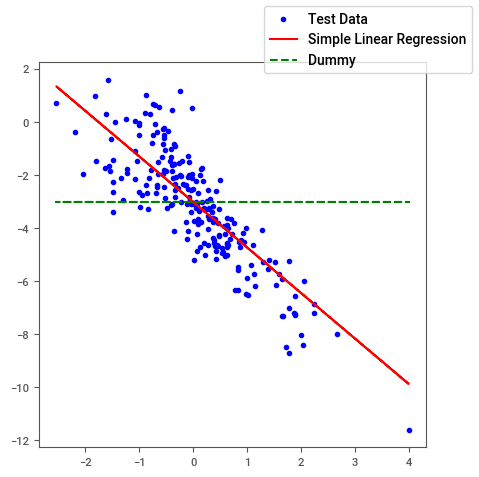

In [38]:
# Create a plot object 
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the test data
ax.scatter(x_test_scaled, y_test, color='blue', label='Test Data')

# Plot the simple linear regression model
ax.plot(x_test_scaled, y_pred_simple, color='red', label='Simple Linear Regression')

# Plot the baseline model
ax.plot(x_test_scaled, y_pred_dummy, "g--", label="Dummy")

# Create the legends
fig.legend(facecolor='white')

# Show the plot
plt.show()

# Building a multifeature linear regression

## Splitting the data

Using the ``MolLogP`` feature with highest correlation with the target variable ``logS`` is a good starting point. The reason is that we knew beforehand that the CLOGP model would be a great predictor of solubility. However, we can improve our model by including other features that show some correlation with the target variable. This is where multiple linear regression comes in.

Let's build a multiple linear regression model using all the features in our dataset. The process is very similar to building a single-feature linear regression model: Once again, we need to scale the data, train the model on the scaled training data using the ``fit`` method, and make predictions on the test data using the ``predict`` function.

We will again split the data into train and test prior to doing any other data cleaning or engineering, to prevent data leakage between the training and testing data. We will use the ``train_test_split`` function from the ``sklearn.model_selection`` module to split the data into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate the model's performance. We will also use a ``random_state `` again, so the data is the same when comparing different models. 

We will drop the target vector 'logS', and also the 'smiles' and 'mol' columns as we do not want the model to use those to predict the solubility.

In [39]:
# Create the feature matrix (x) and target vector (y)
x = df.drop(columns=['logS', 'smiles', 'mol', 'Compound ID'])
y = df['logS']

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)

# Display the shapes of the training and testing sets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((902, 4), (226, 4), (902,), (226,))

<div class="alert alert-block alert-info">
    <b>Note</b>
    Note the usage of <b>X</b> matrix instead of <b>x</b> vector in the <b>train_test_split</b> function, since now we want to use multiple features to predict the target variable.
</div>

### Feature engineering

After splitting our data, we need to scale our training (and test) features. Scaling is a crucial step in the data preprocessing pipeline as it ensures that all features have the same scale as many machine learning models are sensitive to the scale of the input features. We will use the ``StandardScaler`` from the ``sklearn.preprocessing`` module to scale our features. Note that a Random Forest model does not require data scaling, as it is a tree-based model and so different scales will not affect model performance. We will still scale the data, however, so we can also build a linear regression model and compare the performance of two models. 

In [40]:
# Create the standard scaler object
scaler = StandardScaler()

# Fit and transform the training feature vector x_train
x_train_scaled = scaler.fit_transform(x_train)

# Transform the test feature vector x_test
x_test_scaled = scaler.transform(x_test)

# Make sure the training data is scaled correctly
print(f" Training feature mean: {x_train_scaled.mean():.5f}")
print(f" Training feature standard deviation: {x_train_scaled.std():.5f}\n")

# Print the scaler statistics on the test data
print(f" Testing feature mean: {x_test_scaled.mean():.5f}")
print(f" Testing feature standard deviation: {x_test_scaled.std():.5f}")

 Training feature mean: -0.00000
 Training feature standard deviation: 1.00000

 Testing feature mean: 0.07528
 Testing feature standard deviation: 0.99012


<div class="alert alert-block alert-info">
    <b>Reminder:</b>
    It is extremely important to split the data first and then fit the scaler on the training data only. Fitting the scaler on the entire data and then splitting it can cause a <b>data leakage</b> problem which violates our intention to treat the test data as a good representative sample of the real-world data.  
</div>

In [41]:
# Create a linear regression model
multi_feature_model = LinearRegression()

# Fit the model to the training data
multi_feature_model.fit(x_train_scaled, y_train)

# Make predictions on the test data
y_pred_linear_multi = multi_feature_model.predict(x_test_scaled)

# Calculate the performance metrics and store them in a DataFrame
results = pd.DataFrame({
    "MSE": mean_squared_error(y_test, y_pred_linear_multi),     # the mean squared error
    "R2": r2_score(y_test, y_pred_linear_multi)                 # the coefficient of determination
}, index=["Multi-Linear-Regression"])
                            

# Set the formatting style
results.style.format(
    {
        "MSE": "{:.3f}",
        "R2": "{:.2f}"
    }
)

,MSE,R2
Multi-Linear-Regression,1.066,0.77


<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    How much did model performance improve by using a multi-linear model over the linear model? 
</div>

## Building and Training a Random Forest Regression Model

### What is a random forest model?
The next step after the data preparation is to build and train our random forest regression model. A random forest is a decision tree model that uses a "forest" of multiple decision trees and randomly chooses which variables to use in each tree. Generally, each individual tree is not that good at making a prediction, but collectively the trees are quite good at making predictions. Note that each tree predicts an individual value and then a vote is taken (in the case of regression, an average of the predicted values) to determine the final predicted value.

<div style="text-align:center;">
  <img src="Images/Random_forest_explain.png" style="display: block; margin: 0 auto; max-height:400px;">
</div>

### Hyperparameters
Random forest models (and many other models) have hyperparameters that can be 'tuned' to opmitize model performance.The number of trees (``n_iterators``) can be specified, with a default value of 100 trees. Each tree also has a depth(``max_depth``) which specifies the maximum number of splits a tree can have, with the default value being no limit on the depth ('None'). Too few trees or trees that are too shallow results in a model that predicts poorly due to underfitting the data--the model is too simple to predict using train or test data. Too many trees or trees that are too deep results in a model that predicts poorly due to overfitting the data--the model is so complex it can predict using the original data extremely well but cannot predict using new data.

### Building and training a default random forest regression model
We will first build and train a random forest model that uses the default parameters. We will use the ``RandomForestRegressor`` class from the ``sklearn.ensemble`` module to create the model. 

In [42]:
# Create a random forest regression model
default_rf_model = RandomForestRegressor()

# Fit the model to the training data
default_rf_model.fit(x_train_scaled, y_train)

# Make predictions on the test data
y_pred_default_rf = default_rf_model.predict(x_test_scaled)

# Calculate the performance metrics
default_rf_model_results = pd.DataFrame({
    "MSE": mean_squared_error(y_test, y_pred_default_rf),     # the mean squared error
    "R2": r2_score(y_test, y_pred_default_rf)                 # the coefficient of determination
}, index=["Default_RF_Regression"])

# Store the results into results DataFrame
results = pd.concat([results, default_rf_model_results])
results

,MSE,R2
Multi-Linear-Regression,1.065717,0.765724
Default_RF_Regression,0.699586,0.846210


<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Which model is best at predicting the value of logS?
</div>

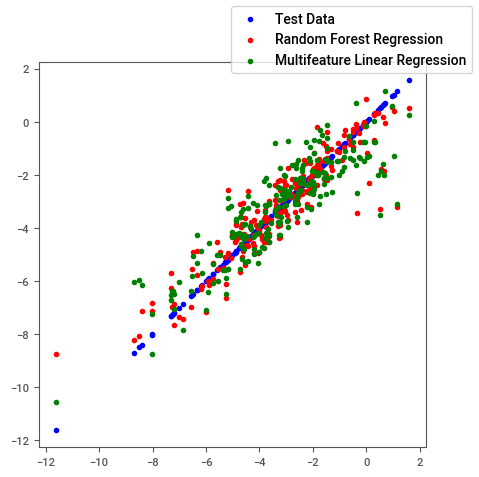

In [43]:
# Create a plot object
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the test data
ax.scatter(y_test, y_test, color='blue', label='Test Data')

# Plot the simple linear regression model
ax.scatter(y_test, y_pred_default_rf, color='red', label='Random Forest Regression')

# Plot the multi-variable linear regression model
ax.scatter(y_test, y_pred_linear_multi, color='green', label="Multifeature Linear Regression")

# Create the legends
fig.legend(facecolor='white')

# Show the plot
plt.show()

### Tuning a Random Forest Regression Model

Our first Random Forest model used the default hyperparameter settings. Tuning (optimizing) hyperparameter settings can improve model performance. We will use a loop to try a range of hyperparameter settings with our model. Although we don't have time to use them today, tools such as ``GridSearchCV`` and ``Optuna`` can be used help identify the best set of hyperparameters. 

In [44]:
# Defining the values to test for the n_iterators and max_depth hyperparameters
trees = [50, 100, 300, 500, 1000]
depths = [1, 3, 5, 7, 9, 11]

## Defining lists to store results for each set of 
tree_count = []
tree_depth = []
tuned_rf_MSE = []
tuned_rf_R2 = []

for tree in trees:
    
    for depth in depths:
        
        # Create a random forest regression model
        tuned_rf_model = RandomForestRegressor(n_estimators = tree, max_depth = depth)

        # Fit the model to the training data
        tuned_rf_model.fit(x_train_scaled, y_train)

        # Make predictions on the test data
        y_pred_tuned_rf = tuned_rf_model.predict(x_test_scaled)

        # Storing the results in lists
        tree_count.append(tree)
        tree_depth.append(depth)
        tuned_rf_MSE.append(mean_squared_error(y_test, y_pred_tuned_rf))
        tuned_rf_R2.append(r2_score(y_test, y_pred_tuned_rf))
        
        
# Create a DataFrame from the lists of results
results_df = pd.DataFrame(
    {'Number of trees': tree_count,
     'Max depth': tree_depth,
     'MSE': tuned_rf_MSE,
     'R2': tuned_rf_R2
    })

# display the results DataFrame
results_df

,Number of trees,Max depth,MSE,R2
0,50,1,2.043877,0.550695
1,50,3,0.943696,0.792547
2,50,5,0.794776,0.825285
3,50,7,0.722511,0.841171
4,50,9,0.704624,0.845103
5,50,11,0.694486,0.847331
6,100,1,2.051345,0.549053
7,100,3,0.955749,0.789898
8,100,5,0.786981,0.826998
9,100,7,0.714338,0.842967


<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Which set of hyperparameters gave the best model performance?
</div>

## Bonus material for more learning

### Improving model performance using cross-validation

You evaluated the performance of our trained model on the test dataset. However, the measured performance depends on the quality of the data in the splits (train/validation/test).
In order to ameliorate this issue, you can use a technique called $k$-fold cross-validation. The $k$-fold cross-validation method splits the data into $k$ subsets,
trains the data on the union of $k-1$ sets and measures the performance of the trained model on the $k$-th set, and repeats the process $k$ times to cover all subsets.
The performance score is reported as the average score of $k$ experiments.

<div style="text-align:center;">
  <img src="Images/K-fold_cross_validation_EN.svg" style="display: block; margin: 0 auto; max-height:400px;">
</div>
<br>
<br>

Here, you can use the ``cross_val_score`` function from the ``sklearn.model_selection`` module to perform a 5-fold cross validation experiment.

You can use cross-validation to train both the multi-feature linear regression model and the random forest regression model. We will again use the ``cross_val_score`` function from the ``sklearn.model_selection`` module to perform a 5-fold cross validation experiment.

In [45]:
# Create a pipeline object
pipeline_multi_feature_linear = make_pipeline(scaler, multi_feature_model)
pipeline_default_rf = make_pipeline(scaler, default_rf_model)

# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Perform cross-validation
cv_results_multi_feature_linear = cross_val_score(pipeline_multi_feature_linear, x, y, cv=kf, scoring="neg_mean_squared_error")
cv_results_default_rf = cross_val_score(pipeline_default_rf, x, y, cv=kf, scoring="neg_mean_squared_error")

# Calculate the mean and standard deviation of the cross-validation results
print(f"CV Results Multifeature Linear Regression Mean MSE: {-cv_results_multi_feature_linear.mean():.5f} +/- {cv_results_multi_feature_linear.std():.5f} ")
print(f"CV Results Default Random Forest Mean MSE: {-cv_results_default_rf.mean():.5f} +/- {cv_results_default_rf.std():.5f}")

CV Results Multifeature Linear Regression Mean MSE: 1.03412 +/- 0.08289 
CV Results Default Random Forest Mean MSE: 0.55468 +/- 0.10230


<div class="alert alert-block alert-success"> 
    <b>Bonus Exercise</b>
    Did using cross-validation improve the performance of the models?
</div>

<div class="alert alert-block alert-success"> 
    <b>Final Exercise</b>
    Where could you use python coding or machine learning in your courses?
</div>